# Вступление

В данной работе рассмотрим нужно было рассмотреть один из вариантов, но я решил разобрать оба варианта решения:
* Классический вариант - в данном варианте преобразуем текст с помощью **TfidfVectorizer**, а в качестве классификатора будем использовать **Catboost**;
* Гибридный вариант - с использованием нейронной сети BERT для формирования признаков и классичиской моделью: **LogisticRegression**, в качестве классификатора;

И в конце сравним какой из вариантов показывает лучший результат.

**ПРИМЕЧАНИЕ:** так как работа носит учебный характер, то все манипуляции с данными будут проводится в усеченном варианте, то есть будет браться часть датасета для обучения и тестирования (2 000 записей). А так же в целях экономии времени не будет проводится углубденный поиск/подбор гиперпараметров для максимилизации итоговой метрики.

## Подготовка

Установим и загрузим необходимые библиотеки для работы

In [2]:
!pip install transformers
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel

In [4]:
df_orig = pd.read_csv('/content/toxic_comments.csv')

Посмотрим на наши данные

In [5]:
df_orig.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Сначала сделаем предпреобразование наших данных

In [6]:
def lemmatize(text):
    lem = WordNetLemmatizer()
    clear_text = ' '.join(re.sub(r'[^a-zA-Z\']', ' ', text).split()).lower().split()
    lemm_list = [lem.lemmatize(word) for word in clear_text]
    ready_text = " ".join(lemm_list)
        
    return ready_text

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Возьмем часть данных, как писалось выше. И дополнительно сбалансируем классы, для корректной работы алгоритмов.

Если выборку не сбалансировать, то в нее может попасть очень малое количество положительных таргетов. И некоторые модели не сумеют найти закономерности, показав 0 метрику.

In [8]:
df_sample = df_orig.sample(n=2000, weights=1./df_orig.groupby('toxic')['toxic'].transform('count'), random_state=101).reset_index(drop=True)
df_sample['pure_text'] = df_sample['text'].apply(lambda x: lemmatize(x))
df_sample.head()

,text,toxic,pure_text
0,"Also, please follow tajik and khosrow's edits....",0,also please follow tajik and khosrow's edits t...
1,"Also, I have the fucking rights to advertise m...",1,also i have the fucking right to advertise my ...
2,Original Arabic lyrics and transliteration dif...,0,original arabic lyric and transliteration diff...
3,|I Done a lot of constructive edits in my shor...,0,i done a lot of constructive edits in my short...
4,You were the one to attack first retard. As fo...,1,you were the one to attack first retard a for ...


In [9]:
df_sample['toxic'].value_counts(normalize=True)

0    0.5125
1    0.4875
Name: toxic, dtype: float64

In [10]:
# для 1, 2 варианта
df_1 = df_sample.copy() 
df_2 = df_sample.copy()

# Обучение моделей

## Вариант 1

Разобьем выборку на три части: тренировочную (80%), валидационную (10%) и тестовую (10%)

In [11]:
df_train1, df_temp = train_test_split(df_1, test_size=0.2, random_state=101)
df_valid1, df_test1 = train_test_split(df_temp, test_size=0.5, random_state=101)

Проверка

In [12]:
print(df_train1.shape, df_valid1.shape, df_test1.shape)

(1600, 3) (200, 3) (200, 3)


Избавимся от стоп-слов и инициализируем **TfidfVectorizer**

In [13]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Данные для обучения

In [14]:
features_train = df_train1.drop(['toxic'], axis=1)
corpus = df_train1['pure_text'].values.astype('U')
features_train1 = count_tf_idf.fit_transform(corpus)
target_train1 = df_train1['toxic']

Данные для валидации

In [15]:
features_valid1 = df_valid1.drop(['toxic'], axis=1)
corpus = df_valid1['pure_text'].values.astype('U')
features_valid1 = count_tf_idf.transform(corpus)
target_valid1 = df_valid1['toxic']

Данные для тестирования

In [16]:
features_test1 = df_test1.drop(['toxic'], axis=1)
corpus = df_test1['pure_text'].values.astype('U')
features_test1 = count_tf_idf.transform(corpus)
target_test1 = df_test1['toxic']

Создадим итоговую таблицу с ключевой метрикой и будем ее наполнять по ходу исследования

In [17]:
result_df = pd.DataFrame(columns=['name_ml', 'F1_valid', 'F1_test'])

In [18]:
%%time
#Время выполнения ячеки около 3 минут
cat = CatBoostClassifier(random_seed=101, 
                               early_stopping_rounds=20, 
                               eval_metric='F1',
                               silent=True)

tuned_parameters = {'depth'         : [8,10],
                    'iterations'    : [60,100]
                   }

best_cat = GridSearchCV(cat, param_grid=tuned_parameters, cv=2, n_jobs=-1)
best_cat.fit(features_train1, target_train1, eval_set=(features_valid1, target_valid1))
target_pred1 = best_cat.predict(features_valid1)

print('***'*40)
print()
print("Best parameters set found on development set:")
print(best_cat.best_params_)
print()
print()
print("Detailed classification report:")
print(classification_report(target_valid1, target_pred1))

************************************************************************************************************************

Best parameters set found on development set:
{'depth': 8, 'iterations': 60}


Detailed classification report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       100
           1       0.91      0.79      0.84       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

CPU times: user 21.9 s, sys: 836 ms, total: 22.7 s
Wall time: 1min 17s


In [19]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
cat_report = classification_report(target_valid1, target_pred1, output_dict=True)
result_df.loc[0]=['TF-IDF + Catboost', round(cat_report['1']['f1-score'], 2), 0]
result_df

,name_ml,F1_valid,F1_test
0,TF-IDF + Catboost,0.84,0


Отлично, рассмотрим следующий вариант

## Вариант 2

Инициализируем токенайзер.

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Преобразуем текст в номера токенов

In [21]:
tokenized = df_2['pure_text'].apply(lambda x: tokenizer.encode(x, max_length = 512, truncation=True, add_special_tokens=True))

Дополним нулями вектора до максимальной длины и создадим маску

In [22]:
padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

In [23]:
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем модель

In [24]:
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Время выполнения - примерно 20 минут
batch_size = 200
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # Преобразуем данные в формат тензоров
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        # Для ускорения используем no_grad() те без градиентов
        with torch.no_grad():
            # Чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        # Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
df_2_ready = pd.DataFrame(np.concatenate(embeddings))
df_2_ready['toxic'] = df_2['toxic']

Разобьем выборку на три части: тренировочную (80%), валидационную (10%) и тестовую (10%)

In [27]:
df_train2, df_temp = train_test_split(df_2_ready, test_size=0.2, random_state=101)
df_valid2, df_test2 = train_test_split(df_temp, test_size=0.5, random_state=101)

Проверка

In [28]:
print(df_train2.shape, df_valid2.shape, df_test2.shape)

(1600, 769) (200, 769) (200, 769)


Данные для обучения

In [29]:
features_train2 = df_train2.drop(['toxic'], axis=1)
target_train2 = df_train2['toxic']

Данные для валидации

In [30]:
features_valid2 = df_valid2.drop(['toxic'], axis=1)
target_valid2 = df_valid2['toxic']

Данные для тестирования

In [31]:
features_test2 = df_test2.drop(['toxic'], axis=1)
target_test2 = df_test2['toxic']

Посмотрим, как с новыми признаками проявит себя **LogisticRegression**

In [32]:
%%time
#Время выполнения ячеки около 1 минут
logreg = LogisticRegression(random_state=101)

tuned_parameters = {"C": [0.4, 0.9],
                    "solver": ['sag', 'saga']
                   }

best_logreg = GridSearchCV(logreg, param_grid=tuned_parameters, cv=2, n_jobs=-1)
best_logreg.fit(features_train2, target_train2)
target_pred2 = best_logreg.predict(features_valid2)

print('***'*40)
print()
print("Best parameters set found on development set:")
print(best_logreg.best_params_)
print()
print()
print("Detailed classification report:")
print(classification_report(target_valid2, target_pred2))

************************************************************************************************************************

Best parameters set found on development set:
{'C': 0.4, 'solver': 'sag'}


Detailed classification report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       100
           1       0.92      0.85      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

CPU times: user 1.53 s, sys: 773 ms, total: 2.3 s
Wall time: 6.73 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [33]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
logreg_report = classification_report(target_valid2, target_pred2, output_dict=True)
result_df.loc[1]=['BERT + LogReg', round(logreg_report['1']['f1-score'], 2), 0]
result_df

,name_ml,F1_valid,F1_test
0,TF-IDF + Catboost,0.84,0
1,BERT + LogReg,0.89,0


----

# Тестирование моделей

### Вариант 1

Проверка на тестовой выборке

In [34]:
print("Detailed classification report:")
target_pred1 = best_cat.predict(features_test1)
print(classification_report(target_test1, target_pred1))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86        98
           1       0.95      0.74      0.83       102

    accuracy                           0.84       200
   macro avg       0.86      0.85      0.84       200
weighted avg       0.86      0.84      0.84       200



In [35]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
cat_report = classification_report(target_test1, target_pred1, output_dict=True)
result_df.loc[0, 'F1_test'] = round(cat_report['1']['f1-score'], 2)
result_df

,name_ml,F1_valid,F1_test
0,TF-IDF + Catboost,0.84,0.83
1,BERT + LogReg,0.89,0


### Вариант 2

Проверим, как **LogisticRegression** справится на тестовой выборке

In [36]:
print("Detailed classification report:")
target_pred2 = best_logreg.predict(features_test2)
print(classification_report(target_test2, target_pred2))

Detailed classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        98
           1       0.93      0.87      0.90       102

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [37]:
#заново создаем отчет, чтобы иметь вывод в словарь, для простого доступа к содержимому
logreg_report = classification_report(target_test2, target_pred2, output_dict=True)
result_df.loc[1, 'F1_test'] = round(logreg_report['1']['f1-score'], 2)
result_df

,name_ml,F1_valid,F1_test
0,TF-IDF + Catboost,0.84,0.83
1,BERT + LogReg,0.89,0.9


# Выводы

In [38]:
result_df

,name_ml,F1_valid,F1_test
0,TF-IDF + Catboost,0.84,0.83
1,BERT + LogReg,0.89,0.9


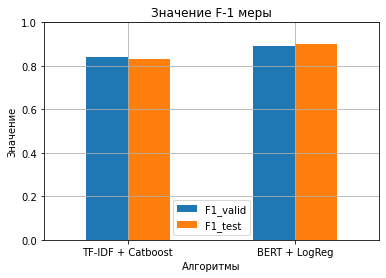

In [39]:
result_df.plot(kind='bar')
plt.title('Значение F-1 меры')
plt.xlabel('Алгоритмы')
plt.ylabel('Значение')
plt.xticks(range(len(result_df['name_ml'])), labels=result_df['name_ml'], rotation=0)
plt.ylim(0,1)
plt.grid()
plt.show()

На основе предоставленных данных было рассмотрено два разных подхода для определения "токсичности" текстов пользователей в интернет магазине "Викишоп". Лучшие значения метрики показал Вариант 2 на основе **BERT & LogisticRegression** c результатом **F-1 = 0.9**.